<a href="https://colab.research.google.com/github/andreiolar77/APS-Labs/blob/main/APS_Andrei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**APS Project Basics**

Import packages that could stand to prove useful. The majority of these packages are pulled straight from Lab 3 and it's packages.

In [ ]:
#useful packages
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import os
import shutil
import pandas as pd

import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
#import splitfolders

Major Goal?
- Devise a Regional Convolutional Neural Network whose goal is to perform the tasks that would typically be mediated by a "Lane Detection" software in a car.
  - This be would include but not limited to:
  - Detect various types of street divisors across the world (our dataset comprises images from Italy, China and Canada)
  - Detect various forms of traffic signs and what they may mean
  - Basic pedestrian detection software
  - Discern these street divisors in hazy, foggy, dark, or blurry (high speed) situations.
  

In [ ]:
#possible additions:
import config
from torchvision import models
import torch.nn.functional as F
from utils import *
import operator
from config import args_setting

*Implemented Feature Highlight:*

Utilization of previous frames (in our case the previous 5) to help predict the new set-up of concurrent and future frames.


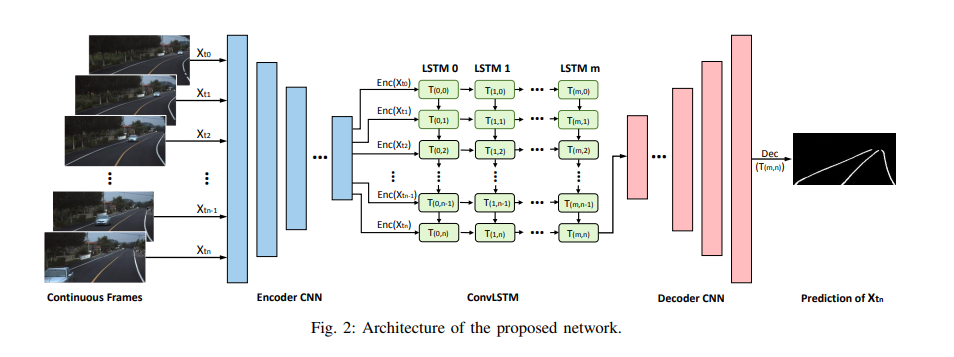


The previous image highlights the basis of the model proposed, using a autoencoder network in tandem with a Convolutional network to help achieve the accuracy improvements. To what magnitude? Accuracy, Precision and Recall all showed significant improvement in this paper in "difficult situations", where light was dim, objects obscured the path, turns were sharp, etc...

(https://arxiv.org/pdf/1903.02193.pdf)


In [ ]:
import torch
import config
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from utils import *
import operator
from config import args_setting

def generate_model(args):

    use_cuda = args.cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    assert args.model in [ 'UNet-ConvLSTM', 'SegNet-ConvLSTM', 'UNet', 'SegNet']
    if args.model == 'SegNet-ConvLSTM':
        model = SegNet_ConvLSTM().to(device)
    elif args.model == 'SegNet':
        model = SegNet().to(device)
    elif args.model == 'UNet-ConvLSTM':
        model =UNet_ConvLSTM(config.img_channel, config.class_num).to(device)
    elif args.model == 'UNet':
        model = UNet(config.img_channel, config.class_num).to(device)
    return model

class UNet_ConvLSTM(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet_ConvLSTM, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        self.convlstm = ConvLSTM(input_size=(8,16),
                                 input_dim=512,
                                 hidden_dim=[512, 512],
                                 kernel_size=(3,3),
                                 num_layers=2,
                                 batch_first=False,
                                 bias=True,
                                 return_all_layers=False)

    def forward(self, x):
        x = torch.unbind(x, dim=1)
        data = []
        for item in x:
            x1 = self.inc(item)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)
            data.append(x5.unsqueeze(0))
        data = torch.cat(data, dim=0)
        lstm, _ = self.convlstm(data)
        test = lstm[0][ -1,:, :, :, :]
        x = self.up1(test, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x, test


class SegNet_ConvLSTM(nn.Module):
    def __init__(self):
        super(SegNet_ConvLSTM,self).__init__()
        self.vgg16_bn = models.vgg16_bn(pretrained=True).features
        self.relu = nn.ReLU(inplace=True)
        self.index_MaxPool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.index_UnPool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # net struct
        self.conv1_block = nn.Sequential(self.vgg16_bn[0],  # conv2d(3,64,(3,3))
                                         self.vgg16_bn[1],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
                                         self.vgg16_bn[2],  # relu(in_place)
                                         self.vgg16_bn[3],  # conv2d(3,64,(3,3))
                                         self.vgg16_bn[4],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
                                         self.vgg16_bn[5]   # relu(in_place)
                                         )
        self.conv2_block = nn.Sequential(self.vgg16_bn[7],
                                         self.vgg16_bn[8],
                                         self.vgg16_bn[9],
                                         self.vgg16_bn[10],
                                         self.vgg16_bn[11],
                                         self.vgg16_bn[12]
                                         )
        self.conv3_block = nn.Sequential(self.vgg16_bn[14],
                                         self.vgg16_bn[15],
                                         self.vgg16_bn[16],
                                         self.vgg16_bn[17],
                                         self.vgg16_bn[18],
                                         self.vgg16_bn[19],
                                         self.vgg16_bn[20],
                                         self.vgg16_bn[21],
                                         self.vgg16_bn[22]
                                         )
        self.conv4_block = nn.Sequential(self.vgg16_bn[24],
                                         self.vgg16_bn[25],
                                         self.vgg16_bn[26],
                                         self.vgg16_bn[27],
                                         self.vgg16_bn[28],
                                         self.vgg16_bn[29],
                                         self.vgg16_bn[30],
                                         self.vgg16_bn[31],
                                         self.vgg16_bn[32]
                                         )
        self.conv5_block = nn.Sequential(self.vgg16_bn[34],
                                         self.vgg16_bn[35],
                                         self.vgg16_bn[36],
                                         self.vgg16_bn[37],
                                         self.vgg16_bn[38],
                                         self.vgg16_bn[39],
                                         self.vgg16_bn[40],
                                         self.vgg16_bn[41],
                                         self.vgg16_bn[42]
                                         )

        self.upconv5_block = nn.Sequential(
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv4_block = nn.Sequential(
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv3_block = nn.Sequential(
                                           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv2_block = nn.Sequential(
                                           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu
                                           )
        self.upconv1_block = nn.Sequential(
                                           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(64, config.class_num, kernel_size=(3, 3), padding=(1,1)),
                                           )
        self.convlstm = ConvLSTM(input_size=(4,8),
                                 input_dim=512,
                                 hidden_dim=[512, 512],
                                 kernel_size=(3,3),
                                 num_layers=2,
                                 batch_first=False,
                                 bias=True,
                                 return_all_layers=False)
    def forward(self, x):
        x = torch.unbind(x, dim=1)
        data = []
        for item in x:
            f1, idx1 = self.index_MaxPool(self.conv1_block(item))
            f2, idx2 = self.index_MaxPool(self.conv2_block(f1))
            f3, idx3 = self.index_MaxPool(self.conv3_block(f2))
            f4, idx4 = self.index_MaxPool(self.conv4_block(f3))
            f5, idx5 = self.index_MaxPool(self.conv5_block(f4))
            data.append(f5.unsqueeze(0))
        data = torch.cat(data, dim=0)
        lstm, _ = self.convlstm(data)
        test = lstm[0][-1,:,:,:,:]
        up6 = self.index_UnPool(test,idx5)
        up5 = self.index_UnPool(self.upconv5_block(up6), idx4)
        up4 = self.index_UnPool(self.upconv4_block(up5), idx3)
        up3 = self.index_UnPool(self.upconv3_block(up4), idx2)
        up2 = self.index_UnPool(self.upconv2_block(up3), idx1)
        up1 = self.upconv1_block(up2)
        return F.log_softmax(up1, dim=1)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


class SegNet(nn.Module):
    def __init__(self):
        super(SegNet,self).__init__()
        self.vgg16_bn = models.vgg16_bn(pretrained=True).features
        self.relu = nn.ReLU(inplace=True)
        self.index_MaxPool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.index_UnPool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # net struct
        self.conv1_block = nn.Sequential(self.vgg16_bn[0],  # conv2d(3,64,(3,3))
                                         self.vgg16_bn[1],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
                                         self.vgg16_bn[2],  # relu(in_place)
                                         self.vgg16_bn[3],  # conv2d(3,64,(3,3))
                                         self.vgg16_bn[4],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
                                         self.vgg16_bn[5]   # relu(in_place)
                                         )
        self.conv2_block = nn.Sequential(self.vgg16_bn[7],
                                         self.vgg16_bn[8],
                                         self.vgg16_bn[9],
                                         self.vgg16_bn[10],
                                         self.vgg16_bn[11],
                                         self.vgg16_bn[12]
                                         )
        self.conv3_block = nn.Sequential(self.vgg16_bn[14],
                                         self.vgg16_bn[15],
                                         self.vgg16_bn[16],
                                         self.vgg16_bn[17],
                                         self.vgg16_bn[18],
                                         self.vgg16_bn[19],
                                         self.vgg16_bn[20],
                                         self.vgg16_bn[21],
                                         self.vgg16_bn[22]
                                         )
        self.conv4_block = nn.Sequential(self.vgg16_bn[24],
                                         self.vgg16_bn[25],
                                         self.vgg16_bn[26],
                                         self.vgg16_bn[27],
                                         self.vgg16_bn[28],
                                         self.vgg16_bn[29],
                                         self.vgg16_bn[30],
                                         self.vgg16_bn[31],
                                         self.vgg16_bn[32]
                                         )
        self.conv5_block = nn.Sequential(self.vgg16_bn[34],
                                         self.vgg16_bn[35],
                                         self.vgg16_bn[36],
                                         self.vgg16_bn[37],
                                         self.vgg16_bn[38],
                                         self.vgg16_bn[39],
                                         self.vgg16_bn[40],
                                         self.vgg16_bn[41],
                                         self.vgg16_bn[42]
                                         )

        self.upconv5_block = nn.Sequential(
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv4_block = nn.Sequential(
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv3_block = nn.Sequential(
                                           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv2_block = nn.Sequential(
                                           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu
                                           )
        self.upconv1_block = nn.Sequential(
                                           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(64, config.class_num, kernel_size=(3, 3), padding=(1,1)),
                                           )
    def forward(self, x):
        f1, idx1 = self.index_MaxPool(self.conv1_block(x))
        f2, idx2 = self.index_MaxPool(self.conv2_block(f1))
        f3, idx3 = self.index_MaxPool(self.conv3_block(f2))
        f4, idx4 = self.index_MaxPool(self.conv4_block(f3))
        f5, idx5 = self.index_MaxPool(self.conv5_block(f4))
        up6 = self.index_UnPool(f5,idx5)
        up5 = self.index_UnPool(self.upconv5_block(up6), idx4)
        up4 = self.index_UnPool(self.upconv4_block(up5), idx3)
        up3 = self.index_UnPool(self.upconv3_block(up4), idx2)
        up2 = self.index_UnPool(self.upconv2_block(up3), idx1)
        up1 = self.upconv1_block(up2)

        return F.log_softmax(up1, dim=1)

ModuleNotFoundError: ignored

We can define a loss function with cross entropy:

E = ∑ 𝑊(x)×log(softmax(x))

where x is defined as a singular sample pixel position.

We should also will incorporate two seperate gradient descent functions to help us train our system.

These are Adam for our "beginning" stages, where the network still needs significant tuning, and a stochastic gradintn descent algorithm for the latter end of our training cycles.

The reason for this choice is that, whilst Adam is powerful, it has a higher gradient descending rate, which can lead it to more easily fall into local minima. After sufficient training, we will utilize a SGD algorithm to find the strongest contender for the global maximum.